# Shift-VAE: Application to 1D spectra with arbitrary offset in peak position

Prepared by Maxim Ziatdinov


---

This notebook denonstrates how to use shift-VAE to disentangle the representations of a 1D spectral data set, ignoring relative positions of the peaks.

---



E-mail: ziatdinovmax@gmail.com

Install pyroVED package:

In [ ]:
# Install the latest version from source
# (or you may instal a stable version from PyPi instead with !pip install pyroved)
!pip install -q git+https://github.com/ziatdinovmax/pyroved.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 732.8/732.8 kB 6.9 MB/s eta 0:00:00


In [ ]:
import os
import math
import numpy as np
import seaborn as sns
import pandas as pd
import time
import random

import torch

from torch.nn import Conv1d, ConvTranspose1d
from torch.nn import Linear as Lin, ReLU, Sigmoid, ConstantPad1d
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold

from matplotlib import pyplot as plt
from tqdm import tqdm

In [ ]:
import pyroved as pv
import torch
import matplotlib.pyplot as plt

First, we prepare our synthetic data representing 1D Gaussian signals with different widths that is randomly shifted along the *x*-axis and is corrupted by noise. In other words, in this example we assume that the only physical factor of variation is a signal width and other forms of variations are considered to be "instrumental distortion".

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

X_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_train.npy")
Y_train = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_train.npy")

X_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_val.npy")
Y_val = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_val.npy")

X_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_X_test.npy")
Y_test = np.load("/content/drive/MyDrive/Aerosols_Proj/Lab_Y_test.npy")

In [ ]:
X_train.shape

(140082, 400, 4)

In [ ]:
Y_train.shape

(140082,)

Text(0.5, 1.0, 'Ch. 3')

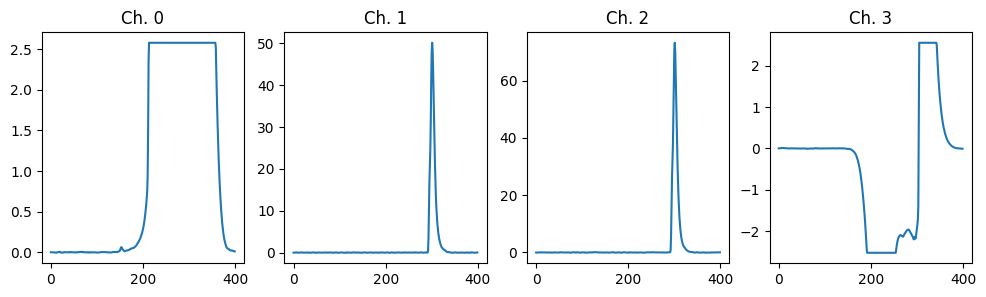

In [ ]:
n = random.randint(1, 140081)
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
axes[0].plot(X_train[n,:,0])
axes[0].set_title("Ch. 0")
axes[1].plot(X_train[n,:,1])
axes[1].set_title("Ch. 1")
axes[2].plot(X_train[n,:,2])
axes[2].set_title("Ch. 2")
axes[3].plot(X_train[n,:,3])
axes[3].set_title("Ch. 3")

In [ ]:
def gaussian(x, mu, sig):
    return torch.exp(-torch.pow(x - mu, 2.) / (2 * torch.pow(sig, 2.)))

n_samples = 5000 # number of samples
l_signal = 100 # signal length

# Generate synthetic dataset with randomly shifted noisy 1D signal
torch.manual_seed(1)  # for reproducibility
x = torch.linspace(-12, 12, l_signal).expand(n_samples, l_signal)
noise = torch.randint(1, 100, (n_samples, 1)) / 1e3
mu = torch.randint(-30, 30, size=(n_samples, 1)) / 10
sig = torch.randint(50, 500, size=(n_samples, 1)) / 1e2
train_data = gaussian(x, mu, sig) + noise * torch.randn(size=(n_samples, l_signal))
# Normalize to (0, 1)
train_data = (train_data - train_data.min()) / (train_data.max() - train_data.min())

# Initialize train loader
train_loader = pv.utils.init_dataloader(train_data.unsqueeze(1), batch_size=64)

In [ ]:
print(type(train_data))

NameError: ignored

In [ ]:
fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    ax.plot(x[0], y[0, 0])

In [ ]:
original_max_X_train = np.zeros((140082, 4))
for p_idx in range(140082):
  for c_idx in range(4):
    original_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])

In [ ]:
channel_min_X_train = np.zeros((140082, 4))
channel_max_X_train = np.zeros((140082, 4))

# WOULD APPLY SAME LOGIC TO VALIDATION AND TEST DATASETS

for p_idx in range(140082):
  for c_idx in range(4):
    channel_min_X_train[p_idx][c_idx] = np.min(X_train[p_idx, :, c_idx])

  for c_idx in range(4):
    channel_max_X_train[p_idx][c_idx] = np.max(X_train[p_idx, :, c_idx])

print(channel_min_X_train[0])
print(channel_max_X_train[0])

for p_idx in range (0,140082):
  for c_idx in range(0, 4):
    s0 = (X_train[p_idx,:,c_idx] - channel_min_X_train[p_idx][c_idx])/(channel_max_X_train[p_idx][c_idx]- channel_min_X_train[p_idx][c_idx])
    X_train[p_idx,:,c_idx] = s0

[-0.00697026 -0.04301787 -0.11002647 -0.23763941]
[ 0.9186803  13.22634017 14.68150232  0.89371128]


In [ ]:
print(type(X_train))

<class 'numpy.ndarray'>


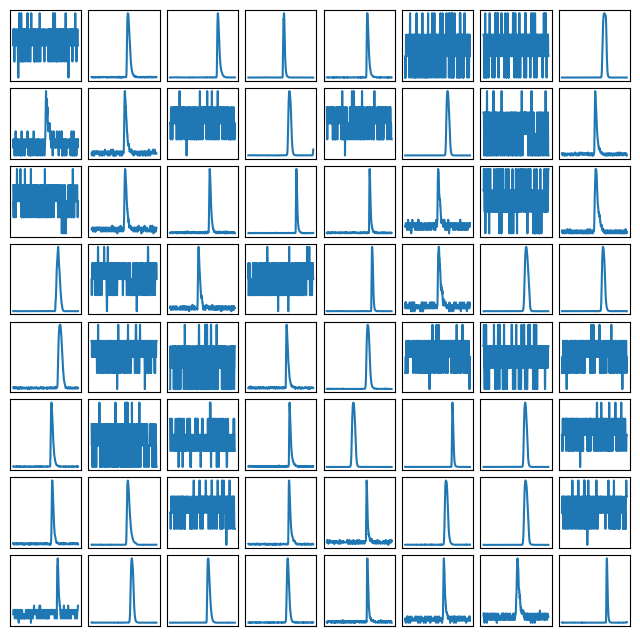

In [ ]:
X_train_C0 = torch.from_numpy(X_train[:,:, 1]).float()

#.unsqueeze(1) adds another channel
train_loader = pv.utils.init_dataloader(X_train_C0.unsqueeze(1), batch_size=64)

fig, axes = plt.subplots(8, 8, figsize=(8, 8),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))

for ax, (y,) in zip(axes.flat, train_loader):
    y_use = y.numpy()
    ax.plot(y_use[0, 0])

Our goal is to find the real/physical descriptor of the data set in an unsupervised fashion, while ignoring (or separating) relative positions of the peaks. First, let's train a regular VAE:

In [ ]:
channel_one = (140081, )

# Initialize vanilla VAE
vae = pv.models.iVAE(data_dim = (400,), latent_dim = 3, invariances=None, seed=0)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(vae)

# Train for n epochs:
for e in range(150):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 146.1990
Epoch: 2 Training loss: 139.6192
Epoch: 3 Training loss: 138.8030
Epoch: 4 Training loss: 138.4409
Epoch: 5 Training loss: 138.2559
Epoch: 6 Training loss: 138.1225
Epoch: 7 Training loss: 138.0242
Epoch: 8 Training loss: 137.9432
Epoch: 9 Training loss: 137.9002
Epoch: 10 Training loss: 137.8371
Epoch: 11 Training loss: 137.7930
Epoch: 12 Training loss: 137.7712
Epoch: 13 Training loss: 137.7333
Epoch: 14 Training loss: 137.7014
Epoch: 15 Training loss: 137.6716
Epoch: 16 Training loss: 137.6342
Epoch: 17 Training loss: 137.6285
Epoch: 18 Training loss: 137.6012
Epoch: 19 Training loss: 137.5857
Epoch: 20 Training loss: 137.5865
Epoch: 21 Training loss: 137.5675
Epoch: 22 Training loss: 137.5605
Epoch: 23 Training loss: 137.5322
Epoch: 24 Training loss: 137.5006
Epoch: 25 Training loss: 137.5167
Epoch: 26 Training loss: 137.5426
Epoch: 27 Training loss: 137.5077
Epoch: 28 Training loss: 137.4808
Epoch: 29 Training loss: 137.4863
Epoch: 30 Training loss

Encode the training data into the latent space:

In [ ]:
#HAVE NOT RUN THIS YET FOR CH. 1

every_50th_sample = X_train_C0[::50]
every_50th_sample.shape

every_50th_sample_y = Y_train[::50]
every_50th_sample_y.shape


(2802,)

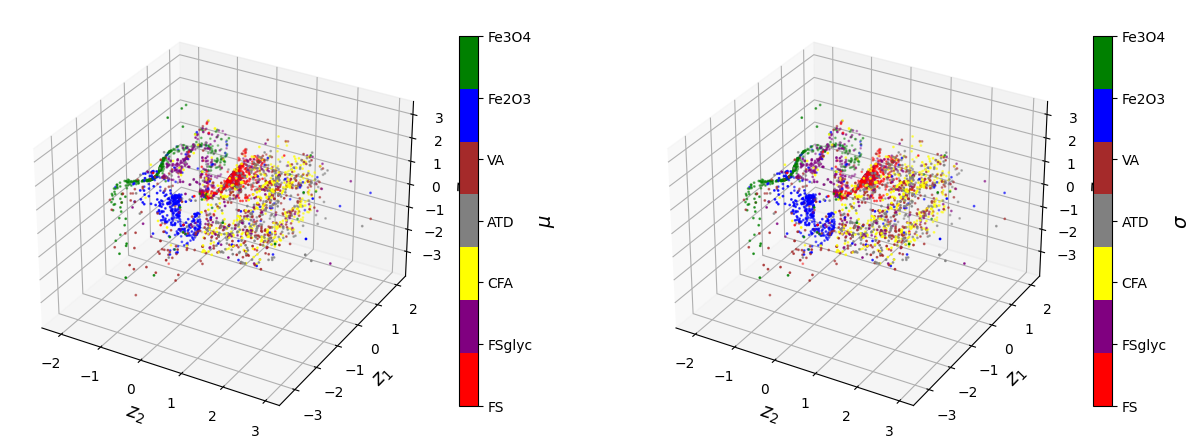

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

z_mean, z_sd = vae.encode(every_50th_sample)
fig = plt.figure(figsize=(15, 6))
ax1 = fig.add_subplot(121, projection='3d')
ax2 = fig.add_subplot(122, projection='3d')
target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]

# Scatter plot with discrete color bar for $\mu$
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])  # Add more colors as needed
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], zs=z_mean[:, -3], s=1, c=every_50th_sample_y, cmap=cmap1)
ax1.set_xlabel("$z_2$", fontsize=14)
ax1.set_ylabel("$z_1$", fontsize=14)
ax1.set_zlabel("$z_3$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, ticks=range(len(cmap1.colors)), shrink=.8)
cbar1.set_ticklabels(target_names)  # Add labels for each class
cbar1.set_label("$\mu$", fontsize=14)

# Scatter plot with discrete color bar for $\sigma$
cmap2 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])  # Add more colors as needed
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], zs=z_mean[:, -3], s=1, c=every_50th_sample_y, cmap=cmap2)
ax2.set_xlabel("$z_2$", fontsize=14)
ax2.set_ylabel("$z_1$", fontsize=14)
ax2.set_zlabel("$z_3$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, ticks=range(len(cmap2.colors)), shrink=.8)
cbar2.set_ticklabels(target_names)  # Add labels for each class
cbar2.set_label("$\sigma$", fontsize=14)

plt.show()

Plot the learned latent manifold:

In [ ]:
vae.manifold2d(d=10);

RuntimeError: ignored

The results are not that bad! We can see that one of the latent variables is (mostly) associated with peak shifts and another one is (mostly) associated with changes in width. Now let's plot our latent variables versus the ground truth data (i.e., actual peak shift and changes in width):

In [ ]:
channel_max_X_train.shape

(140082, 4)

In [ ]:
every_50th_sample_originalMax = original_max_X_train[::50]
every_50th_sample_originalMax.shape

(2802, 4)

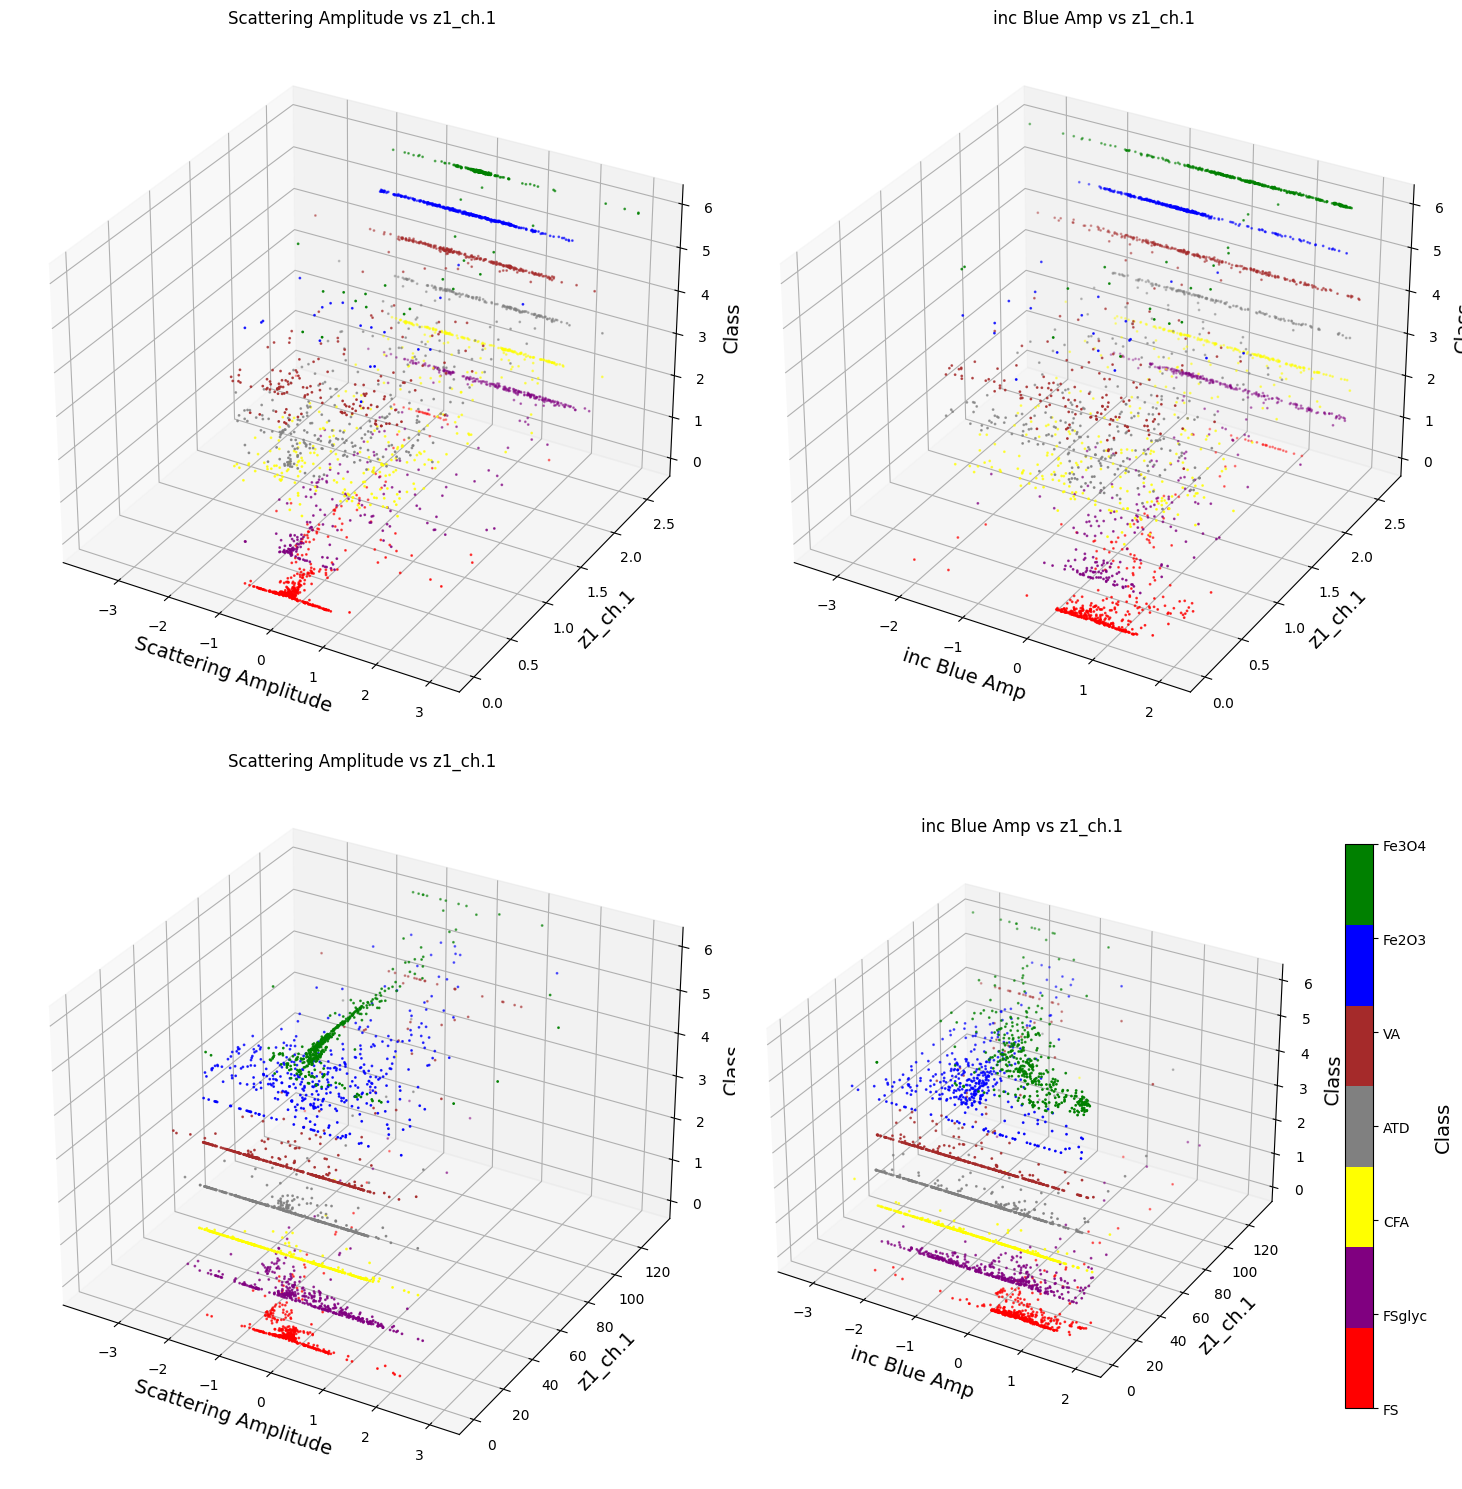

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap

target_names = ["FS", "FSglyc", "CFA", "ATD", "VA", "Fe2O3", "Fe3O4"]
cmap1 = ListedColormap(['red', 'purple', 'yellow', 'gray', 'brown', 'blue', 'green'])

fig = plt.figure(figsize=(15, 15))
ax = fig.subplots(2, 2, subplot_kw={'projection': '3d'})

# Scatter plot with 3D axes for the first subplot
scatter1 = ax[0, 0].scatter(z_mean[:, 0], every_50th_sample_originalMax[:, 0], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[0, 0].set_xlabel("Scattering Amplitude", fontsize=14)
ax[0, 0].set_ylabel("z1_ch.1", fontsize=14)
ax[0, 0].set_zlabel("Class", fontsize=14)
ax[0, 0].set_title("Scattering Amplitude vs z1_ch.1")

# Scatter plot with 3D axes for the second subplot
scatter2 = ax[0, 1].scatter(z_mean[:, 1], every_50th_sample_originalMax[:, 0], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[0, 1].set_xlabel("inc Blue Amp", fontsize=14)
ax[0, 1].set_ylabel("z1_ch.1", fontsize=14)
ax[0, 1].set_zlabel("Class", fontsize=14)
ax[0, 1].set_title("inc Blue Amp vs z1_ch.1")

# Scatter plot with 3D axes for the third subplot
scatter3 = ax[1, 0].scatter(z_mean[:, 0], every_50th_sample_originalMax[:, 1], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[1, 0].set_xlabel("Scattering Amplitude", fontsize=14)
ax[1, 0].set_ylabel("z1_ch.1", fontsize=14)
ax[1, 0].set_zlabel("Class", fontsize=14)
ax[1, 0].set_title("Scattering Amplitude vs z1_ch.1")

# Scatter plot with 3D axes for the fourth subplot
scatter4 = ax[1, 1].scatter(z_mean[:, 1], every_50th_sample_originalMax[:, 1], zs=every_50th_sample_y, c=every_50th_sample_y, cmap=cmap1, s=1)
ax[1, 1].set_xlabel("inc Blue Amp", fontsize=14)
ax[1, 1].set_ylabel("z1_ch.1", fontsize=14)
ax[1, 1].set_zlabel("Class", fontsize=14)
ax[1, 1].set_title("inc Blue Amp vs z1_ch.1")

# Add a color bar to the last subplot
cbar = fig.colorbar(scatter4, ax=ax[1, 1], ticks=range(len(cmap1.colors)), shrink=0.8)
cbar.set_ticklabels(target_names)  # Add labels for each class
cbar.set_label("Class", fontsize=14)

plt.tight_layout()
plt.show()

We can see that while there is definitely a relationship between ground truth variables and the encoded latent variables, they are not equal (even after if we do a "rescaling").

Now let's see if a shift-invariant VAE model can do better. In the shift-VAE, we have one latent variable designated to absorb the information about shifts, whereas the remaining latent variables encode the remaining factors of variation.

Let's initialize and train the shift-VAE model:

In [ ]:
in_dim = (100,)

# Initialize shift-invariant VAE (to do this we add 't' to invariances)
svae = pv.models.iVAE(in_dim, latent_dim=2, invariances=['t'], dx_prior=.3)

# Initialize SVI trainer
trainer = pv.trainers.SVItrainer(svae)

# Train for n epochs:
for e in range(250):
    trainer.step(train_loader)
    trainer.print_statistics()

Epoch: 1 Training loss: 65.0912
Epoch: 2 Training loss: 61.7285
Epoch: 3 Training loss: 60.9334
Epoch: 4 Training loss: 60.8464
Epoch: 5 Training loss: 60.7520
Epoch: 6 Training loss: 60.6943
Epoch: 7 Training loss: 60.7085
Epoch: 8 Training loss: 60.6276
Epoch: 9 Training loss: 60.6231
Epoch: 10 Training loss: 60.6109
Epoch: 11 Training loss: 60.6310
Epoch: 12 Training loss: 60.6065
Epoch: 13 Training loss: 60.5824
Epoch: 14 Training loss: 60.5638
Epoch: 15 Training loss: 60.5601
Epoch: 16 Training loss: 60.5462
Epoch: 17 Training loss: 60.5450
Epoch: 18 Training loss: 60.5440
Epoch: 19 Training loss: 60.5456
Epoch: 20 Training loss: 60.5469
Epoch: 21 Training loss: 60.5121
Epoch: 22 Training loss: 60.5336
Epoch: 23 Training loss: 60.5181
Epoch: 24 Training loss: 60.5043
Epoch: 25 Training loss: 60.5614
Epoch: 26 Training loss: 60.5497
Epoch: 27 Training loss: 60.5286
Epoch: 28 Training loss: 60.5110
Epoch: 29 Training loss: 60.5055
Epoch: 30 Training loss: 60.5109
Epoch: 31 Training 

Encode train data into the latent space:

In [ ]:
z_mean, z_sd = svae.encode(train_data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
im1 = ax1.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=mu)
ax1.set_xlabel("$z_1$", fontsize=14)
ax1.set_ylabel("$z_2$", fontsize=14)
cbar1 = fig.colorbar(im1, ax=ax1, shrink=.8)
cbar1.set_label("$\mu$", fontsize=14)
# ax1.set_xlim(-2, 2)
# ax1.set_ylim(-2, 2)
im2 = ax2.scatter(z_mean[:, -1], z_mean[:, -2], s=1, c=sig)
ax2.set_xlabel("$z_1$", fontsize=14)
ax2.set_ylabel("$z_2$", fontsize=14)
cbar2 = fig.colorbar(im2, ax=ax2, shrink=.8)
cbar2.set_label("$\sigma$", fontsize=14)
# ax2.set_xlim(-2, 2)
# ax2.set_ylim(-2, 2);

NameError: ignored

Note that the latent space is clearly collapsed, with the data points forming an 1D manifold. Classically in VAEs, this collapse of latent space is perceived as a problem calling for the adjustment of the "loss" function. However, here we know that our ground truth data set has only two factors of variability, one of which is position. Hence, the dimensionality of our latent space hints at the true physical dimensionality of the data!

Now let's plot the learned latent manifold of the shift-VAE:

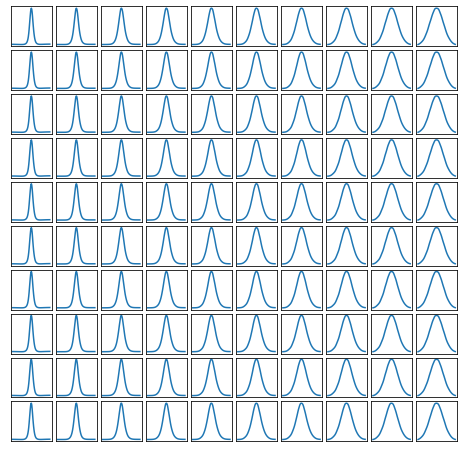

In [ ]:
svae.manifold2d(d=10);

As mentioned above, the information about shifts is now encoded in the first latent variables so let's plot it against the real shift. We also plot a non-collapsed latent variable against the ground truth values of peak width.

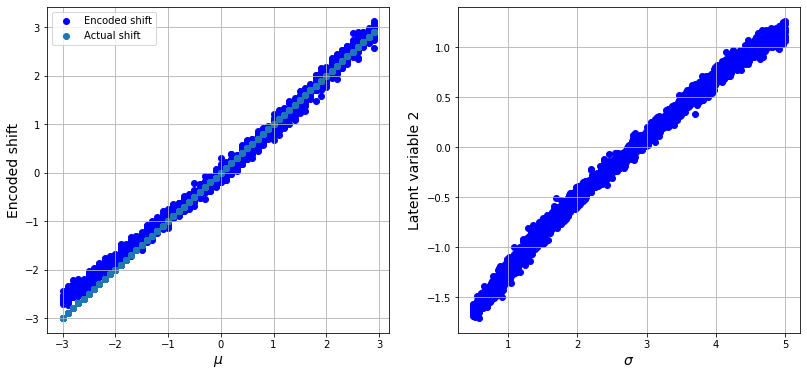

In [ ]:
rescale = ((x.max() - x.min()) / 2 ) * svae.t_prior.cpu() # rescaling coefficient for shift latent variable
i = 2 # non-collapsed latent variable
_, (ax1, ax2) = plt.subplots(1, 2, figsize=(13.5, 6))
ax1.scatter(mu, z_mean[:, 0] * rescale, c='blue', label="Encoded shift")
ax1.scatter(mu, mu, label="Actual shift")
ax1.set_xlabel("$\mu$", fontsize=14)
ax1.set_ylabel("Encoded shift", fontsize=14)
ax1.legend()
ax1.grid()
ax2.scatter(sig, z_mean[:, i], c='blue')
ax2.set_xlabel("$\sigma$", fontsize=14)
ax2.set_ylabel("Latent variable {}".format(i), fontsize=14)
ax2.grid()

Looks pretty good! We see mostly linear relationships and a big improvement compared to standard VAE. You may try playing with a KL scale factor and/or parameters of the encoder and decoder neural networks to get a further improvememnt.